In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization,Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold


In [64]:
from preprocess import *

In [65]:
def extract_network_parcels(two_back, no_back, region_info, network_name):
    # Identify the indices of the 'Frontopariet' network
    fpn_indices = [i for i, network in enumerate(region_info['network']) if network == network_name]

    two_back_network = []
    no_back_network = []

    # Extract Frontopariet parcels for two_back
    for subject_two_back in two_back:
        SpecialNetwork_two_back = subject_two_back[fpn_indices, :]  # Assuming subject_two_back is a numpy array
        two_back_network.append(SpecialNetwork_two_back)

    # Extract Frontopariet parcels for no_back
    for subject_no_back in no_back:
        SpecialNetwork_no_back = subject_no_back[fpn_indices, :]  # Assuming subject_no_back is a numpy array
        no_back_network.append(SpecialNetwork_no_back)

    return two_back_network, no_back_network
two_back_fpn, no_back_fpn = extract_network_parcels(two_back, no_back, region_info, 'Frontopariet')
two_back_fpn=np.array(two_back_fpn)
no_back_fpn=np.array(no_back_fpn)
print (f'two_back_fpn shape:{two_back_fpn.shape}')
print(f'no_back_fpn shape:{no_back_fpn.shape}')

two_back_fpn shape:(339, 50, 312)
no_back_fpn shape:(339, 50, 312)


In [66]:
n_subjects=339
# Split data by subjects
split_percentage = 85
n_train_subjects = int((split_percentage / 100) * n_subjects)
train_indices = np.arange(n_train_subjects)
test_indices = np.arange(n_train_subjects, n_subjects)

# Training data
no_back_train = no_back_fpn[train_indices]
two_back_train = two_back_fpn[train_indices]
# Testing data
no_back_test = no_back_fpn[test_indices]
two_back_test = two_back_fpn[test_indices]
# Combine the original data
X_train = np.concatenate((no_back_train, two_back_train), axis=0)
X_test = np.concatenate((no_back_test, two_back_test), axis=0)
X_train = np.transpose(X_train, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))
# Make label array
y_train = np.zeros(X_train.shape[0])
y_train[len(no_back_train):] = 1
y_test = np.zeros(X_test.shape[0])
y_test[len(no_back_test):] = 1


print(f'X_train shape is {X_train.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_test shape is {y_test.shape}')


X_train shape is (576, 312, 50)
X_test shape is (102, 312, 50)
y_train shape is (576,)
y_test shape is (102,)


In [67]:
df = pd.read_csv('./Sliding_mmse.csv')
X = np.array(df["mmse"])
features_array = X.reshape((-1,11))
split_ratio = 0.85
n_train = int(split_ratio * features_array.shape[0])
entropy_train = features_array[:n_train,:]
entropy_test = features_array[n_train:,:]

print(f'entropy_train shape is {entropy_train.shape}')
print(f'entropy_test shape is {entropy_test.shape}')

# # # Shuffle the data while maintaining alignment
X_train, y_train, entropy_train = shuffle(X_train, y_train, entropy_train, random_state=42)
X_test, y_test, entropy_test = shuffle(X_test, y_test, entropy_test, random_state=42)

scalers={}
for i in range(X_train.shape[2]):
  scalers[i] = StandardScaler()
  X_train[:,:,i] = scalers[i].fit_transform(X_train[:,:,i])
  X_test[:,:,i] = scalers[i].fit_transform(X_test[:,:,i])
  
entropy_scaler = StandardScaler()
entropy_train_scaled= entropy_scaler.fit_transform(entropy_train)
entropy_test_scaled = entropy_scaler.fit_transform(entropy_test)

entropy_train shape is (576, 11)
entropy_test shape is (102, 11)


Step 1: Train the Model Without Entropy Features

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.5718 - loss: 2.2391 - val_accuracy: 0.5259 - val_loss: 2.1270 - learning_rate: 5.0000e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6347 - loss: 2.1176 - val_accuracy: 0.5603 - val_loss: 2.0501 - learning_rate: 5.0000e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.6365 - loss: 1.9958 - val_accuracy: 0.6121 - val_loss: 1.9800 - learning_rate: 5.0000e-04
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6958 - loss: 1.9160 - val_accuracy: 0.6207 - val_loss: 1.9157 - learning_rate: 5.0000e-04
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6699 - loss: 1.8578 - val_accuracy: 0.6379 - val_loss: 1.8509 - learning_rate: 5.0000e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.7106 - loss: 1.8022 - val_accuracy: 0.6379 - val_loss: 1.7876 - learning_rate: 5.0000e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7905 - loss:

Test accuracy without entropy features: 0.8333


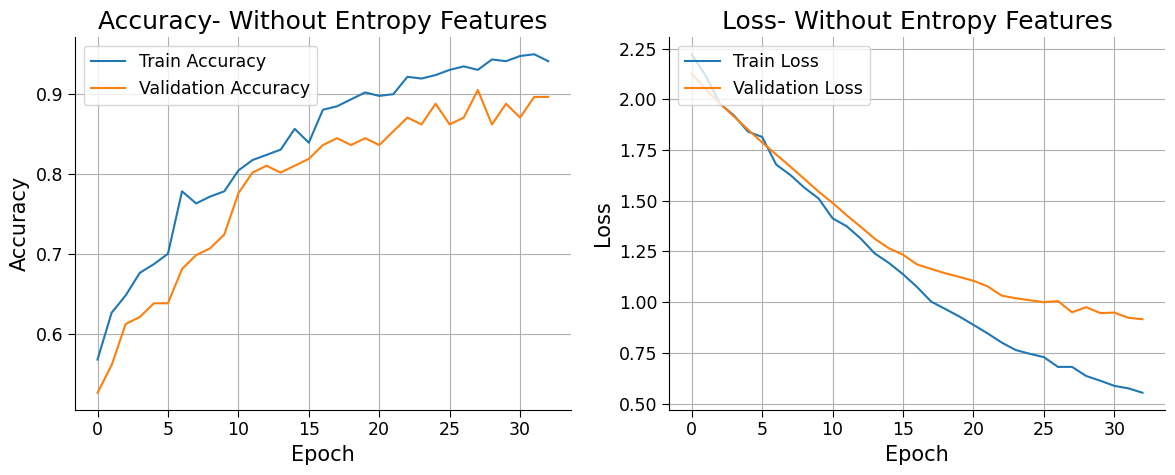

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


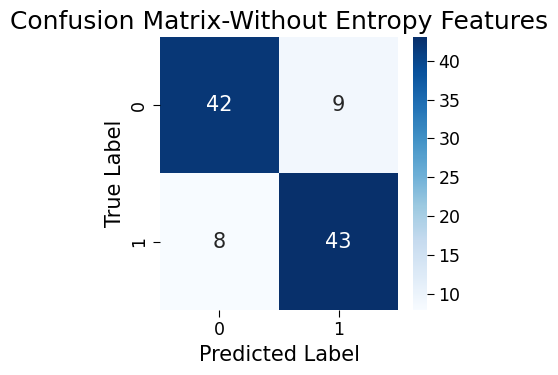

In [77]:
sequence_length = 312
n_signal = 50
# Sequence Input and GRU Layers
sequence_input = Input(shape=(sequence_length, n_signal), name='gru_input')
gru1 = GRU(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01))(sequence_input)
gru1 = Dropout(0.5)(gru1)
gru1 = BatchNormalization()(gru1)
gru2 = GRU(32, activation='relu', return_sequences=False, kernel_regularizer=l2(0.01))(gru1)
gru2 = Dropout(0.5)(gru2)
gru_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(gru2)

# Compile the model
gru_model = Model(inputs=sequence_input, outputs=gru_output)
gru_model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Train with early stopping based on validation accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

history = gru_model.fit(
    X_train, y_train, 
    batch_size=64, epochs=50, 
    validation_split=0.2, 
    callbacks=[early_stopping, reduce_lr]
)


# Save the Improved Model Without Entropy Features
gru_model.save('model_without_entropy.h5')

# Evaluate the Improved Model Without Entropy Features
test_loss, test_accuracy = gru_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy without entropy features: {test_accuracy:.4f}')

# Plot the Training History
plt.figure(figsize=(12, 5))
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy- Without Entropy Features')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss- Without Entropy Features')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Generate Confusion Matrix
y_pred_without_entropy = gru_model.predict(X_test)
y_pred_without_entropy = np.where(y_pred_without_entropy > 0.5, 1, 0)
cf_matrix_without_entropy = tf.math.confusion_matrix(y_test, y_pred_without_entropy)

# Plotting the confusion matrix 
plt.figure(figsize=(4, 4))
sns.heatmap(cf_matrix_without_entropy, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0-back', '2-back'], 
            yticklabels=['0-back', '2-back'])
plt.title('Confusion Matrix With Entropy Features')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Step 2: Load the Model and Train It with Added Entropy Features

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step - accuracy: 0.5016 - loss: 1.3657 - val_accuracy: 0.4569 - val_loss: 1.2379 - learning_rate: 5.0000e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - accuracy: 0.4638 - loss: 1.2384 - val_accuracy: 0.4828 - val_loss: 1.1610 - learning_rate: 5.0000e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.4801 - loss: 1.1739 - val_accuracy: 0.4828 - val_loss: 1.1113 - learning_rate: 5.0000e-04
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.4981 - loss: 1.1074 - val_accuracy: 0.4828 - val_loss: 1.0677 - learning_rate: 5.0000e-04
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.5446 - loss: 1.0627 - val_accuracy: 0.5000 - val_loss: 1.0378 - learning_rate: 5.0000e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.4797 - loss: 1.0501 - val_accuracy: 0.5345 - val_loss: 1.0106 - learning_rate: 5.0000e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - accuracy: 0.5258 - loss:

Test accuracy with frozen layers and entropy features: 0.8725


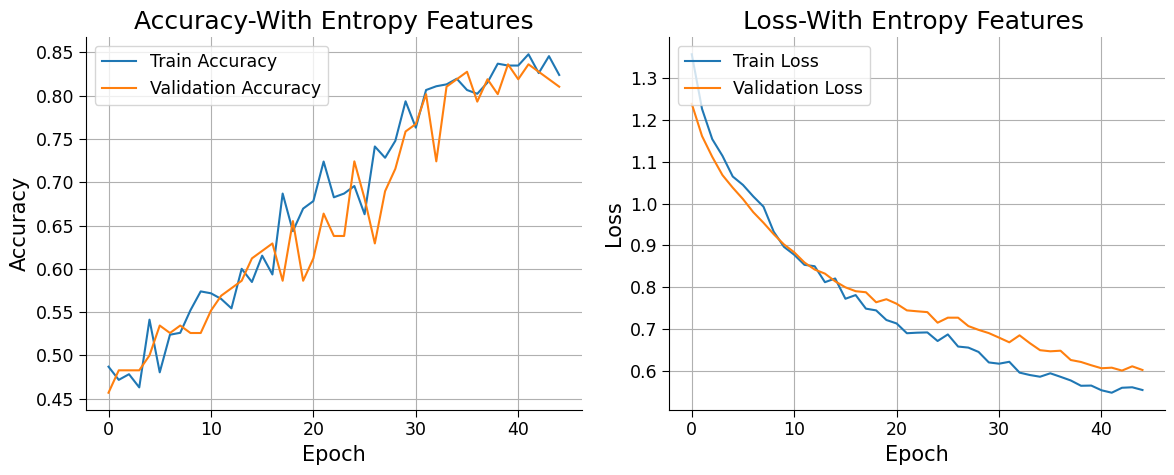

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


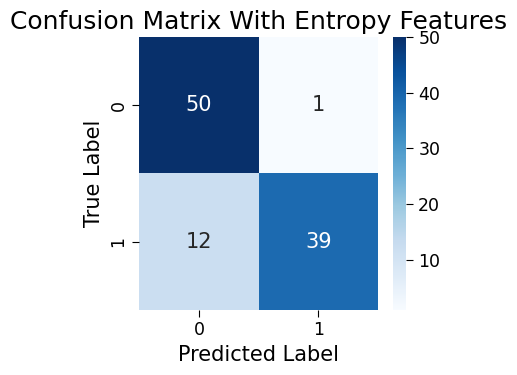

In [91]:
# Load the Pre-Trained Model
model_without_entropy = load_model('model_without_entropy.h5')

# Create a New Input Layer for the Entropy Features
entropy_input = Input(shape=(11,), name='entropy_input')
# Get the Output of the Last Layer of the Frozen GRU Model
gru_output = model_without_entropy.output
# Combine the GRU Output with the Entropy Input
combined = Concatenate()([gru_output, entropy_input])

# Dense Layers on Top
x = Dense(64, activation='relu' ,kernel_regularizer=l2(0.01))(combined)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
combined_output = Dense(1, activation='sigmoid')(x)

# Create and Compile the New Model with Entropy Features
model_with_entropy = Model(inputs=[model_without_entropy.input, entropy_input], outputs=combined_output)
model_with_entropy.compile(optimizer=RMSprop(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the Model with Entropy Features
history_with_entropy = model_with_entropy.fit(
    [X_train, entropy_train_scaled], y_train, 
    batch_size=64, epochs=50, 
    validation_split=0.2, 
    callbacks=[early_stopping, reduce_lr]
)

# Save the Model with Entropy Features
model_with_entropy.save('model_with_entropy.h5')

# Evaluate the Model with Entropy Features
test_loss_with_entropy, test_accuracy_with_entropy = model_with_entropy.evaluate([X_test, entropy_test_scaled], y_test, verbose=0)
print(f'Test accuracy with entropy features: {test_accuracy_with_entropy:.4f}')

# Plot the Training History with Entropy Features
plt.figure(figsize=(12, 5))
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_with_entropy.history['accuracy'], label='Train Accuracy')
plt.plot(history_with_entropy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy-With Entropy Features')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_with_entropy.history['loss'], label='Train Loss')
plt.plot(history_with_entropy.history['val_loss'], label='Validation Loss')
plt.title('Loss-With Entropy Features ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Generate Confusion Matrix with Entropy Features
y_pred_with_entropy = model_with_entropy.predict([X_test, entropy_test_scaled])
y_pred_with_entropy = np.where(y_pred_with_entropy > 0.5, 1, 0)
cf_matrix_with_entropy = tf.math.confusion_matrix(y_test, y_pred_with_entropy)

plt.figure(figsize=(4, 4))
sns.heatmap(cf_matrix_with_entropy, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0-back', '2-back'], 
            yticklabels=['0-back', '2-back'])
plt.title('Confusion Matrix With Entropy Features')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()